<a href="https://colab.research.google.com/github/SahputraS/Outbreak-Simulation-and-Detection-Testing/blob/main/Outbreak_Detection_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The outbreak detection evaluation framework here is based on the paper below:
https://www.medrxiv.org/content/10.1101/2022.03.16.22272469v2

The framework above is appplied to a toy example already calculated manually below:
https://docs.google.com/spreadsheets/d/1N8BiW6pvMa4Au3yn8gAhwaymc0paJSseOB0jxsSwWEM/edit?usp=sharing

In [1]:
import numpy as np
import pandas as pd
import string
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

## Making the toy scenario - Ground Truth
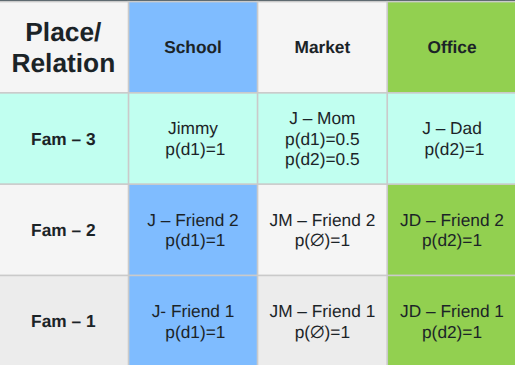

In [2]:
data = [
    ("School", "f3", "Jimmy", "d1"),
    ("Market", "f3", "J – Mom", "d1"),
    ("Market", "f3", "J – Mom", "d2"),
    ("Office", "f3", "J – Dad", "d2"),

    ("School", "f2", "J – Friend 2", "d1"),
    ("Market", "f2", "JM – Friend 2", "non_case"),
    ("Office", "f2", "JD – Friend 2", "d2"),

    ("School", "f1", "J – Friend 1", "d1"),
    ("Market", "f1", "JM – Friend 1", "non_case"),
    ("Office", "f1", "JD – Friend 1", "d2"),
]

sample = pd.DataFrame(data, columns=["place", "family", "person", "disease"])

In [3]:
sample

,place,family,person,disease
0,School,f3,Jimmy,d1
1,Market,f3,J – Mom,d1
2,Market,f3,J – Mom,d2
3,Office,f3,J – Dad,d2
4,School,f2,J – Friend 2,d1
5,Market,f2,JM – Friend 2,non_case
6,Office,f2,JD – Friend 2,d2
7,School,f1,J – Friend 1,d1
8,Market,f1,JM – Friend 1,non_case
9,Office,f1,JD – Friend 1,d2


## Making the toy scenario - Outbreak Detection Signal

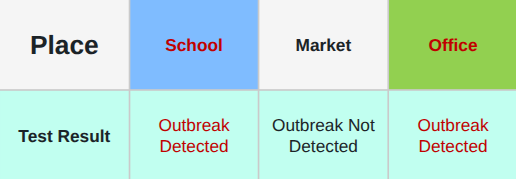

In [4]:
data2 = [
    ("School", 1),
    ("Office", 1),
    ("Market", 0),
]

outbreak_sig = pd.DataFrame(data2, columns=["place", "signal"])

In [5]:
outbreak_sig

,place,signal
0,School,1
1,Office,1
2,Market,0


The calculation to get to the probabilities is based on the data format input above. It is not yet generalized or have many layers of rechecking the correct format/input and such.

## Calculate the probability of each disease in each cell p(d|x)

In [6]:
def truth_label(df, x_cols, disease_col):
    '''
    INPUT
    df: ground_truth DataFrame
    x_cols: a list of column names in the ground truth DataFrame that corresponds to the coordinates in a grid
    disease_col: the column name in the ground truth DataFrame that corresponds to the disease
    '''

    cell_counts = df.groupby(x_cols).transform("count")[disease_col] # Number of diseases in each unique cell (as defined by x_cols)
    df["p(d|x)"] = 1 /cell_counts # Uniform probability of each disease in its cell: p(d|x) = 1/(number of unique diseases in that cell)
    return df

## Calculate the Weight and p(s|x)

In [7]:
def signal_code(outbreak_df, signal_col):
  '''
  Function that takes the signal from outbreak detector and gives each signal source an ID in a form of unique letter

  INPUT
  outbreak_df: outbreak detection signal in DataFrame
  signal_col: the column name in the outbreak detection signal DataFrame that corresponds to the signal
  '''
  letters = list(string.ascii_uppercase)
  outbreak_df["code"] = letters[:len(outbreak_df)] # Associate different signal source with a letter as a code
  outbreak_df["S_code"] = outbreak_df["code"]*(outbreak_df[signal_col]).astype(int) # Take only the one that produces positive output (e.g. value 1)
  outbreak_df.replace('', np.nan, inplace=True) # Else it would be NaN
  return outbreak_df

In [8]:
def weight_assignment (test_df, outbreak_coded_df, weight_value):
  '''
  INPUT
  test_df: outbreak detection signal that is already mapped to the grid with the weight information in DataFrame
  outbreak_coded_df: outbreak detection signal that already assigned singal code in DataFrame
  weight_value: the value for the weight (now it is just a simple int number)
  '''
  test_df = test_df.merge(outbreak_coded_df[["place", "S_code"]], on="place", how="left")

  # Adding the endemic and the non_sig case
  test_df.loc[test_df["S_code"].isna() & (test_df["sick"] == 1), "S_code"] = "endemic"
  test_df.loc[test_df["S_code"].isna() & (test_df["sick"] == 0), "S_code"] = "no_sig"

  test_df['W_value'] = weight_value # Weight the same for all active signal due to the nature of the outbreak detection in this toy model
  return test_df

In [9]:
def p_s_given_x(test_df, x_cols, weight_col, s_code_col):
  '''
  This function calculate the p(s|x) = w(s,x)/ sum(weights in a cell) and add the results as a column in the input DataFrame

  INPUT
  test_df: outbreak detection signal that is already mapped to the grid with the weight information in DataFrame
  x_cols: a list of column names in the ground truth DataFrame that corresponds to the coordinates in a grid
  weight_col: the column name in the outbreak detection signal DataFrame that corresponds to the weight
  s_code_col: the column name in the outbreak detection signal DataFrame that corresponds to the active signal code
  '''
  test_df["p(s|x)"] = test_df.groupby(x_cols+[s_code_col]).transform("nunique")["W_value"]
  test_df["p(s|x)"] = 1/test_df["p(s|x)"]
  return test_df

## Calculate p(d|s)

In [10]:
def calc_flat_prior(df_truth_label, outbreak_coded_df, disease_col, signal_col):

  '''
  This function calculates the prior, i.e. p(d|s)
  INPUT
  df_truth_label: ground_truth already labeled in DataFrame
  outbreak_coded_df: outbreak detection signal that already assigned singal code in DataFrame
  disease_col: the column name in the ground truth DataFrame that corresponds to the disease
  signal_col: the column name in the outbreak detection signal DataFrame that corresponds to the signal
  '''

  # Catalogue the disease in the ground truth outside the endemic and non_case
  disease_list_df = pd.DataFrame({disease_col: df_truth_label.loc[~df_truth_label[disease_col].isin(["non_case", "endemic"]), disease_col].unique()})

  # Because of the flat posterior based on the detectors signal
  prior_df =  outbreak_coded_df[["code", signal_col]].copy()
  prior_df = prior_df.merge(disease_list_df, how="cross")
  prior_df['active_sig'] = (prior_df[signal_col]*prior_df['code']).replace('', np.nan)

  prior_df["p(d|s)"] = prior_df.groupby([disease_col]).transform("nunique")["active_sig"]
  prior_df["p(d|s)"] = 1/prior_df["p(d|s)"]*prior_df[signal_col]
  prior_df = prior_df.drop(columns=["active_sig", signal_col])

  # Add the prior probability for the endemic and no_sig case
  prior_df.loc[len(prior_df)] = ["endemic", "endemic", 1.0]
  prior_df.loc[len(prior_df)] = ["no_sig", "no_sig", 1.0]

  return prior_df

In [11]:
def calc_p_hat(test_df, prior_df, x_cols, disease_col, id_col=None):
  '''
  test_df: outbreak detection signal that is already mapped to the grid with the p(s|x) information in it
  prior_df: prior DataFrame that contains information about the p(d|s)
  x_cols: a list of column names in the ground truth DataFrame that corresponds to the coordinates in a grid
  disease_col: column name in the ground truth DataFrame that corresponds to the disease
  id_col : column name in the ground truth DataFrame that corresponds to the cell occupant name (if exist)
  '''

  test_df = test_df.merge(prior_df, left_on="S_code", right_on="code", how="outer")
  test_df = test_df.dropna()
  test_df = test_df.drop(columns=["code"])
  test_df['post'] = test_df['p(d|s)']*test_df['p(s|x)']


  if id_col:
      if isinstance(id_col, str):
          id_cols = [id_col]
      else:
          id_cols = list(id_col)
      output_df = test_df.groupby(id_cols + x_cols + [disease_col], as_index=False)['post'].sum()

  output_df.rename(columns={"post": "p_hat"}, inplace=True)
  return output_df

In [12]:
def outbreak_sig_process(df_truth, outbreak_sig, x_cols, disease_col, signal_col, id_col=None):
  '''
  PROTOTPYE 1
  This function processes the ground truth signal and assigns labels to it (i.e., computes p(d|x)).
  It also takes the outbreak detection signal and calculates the posterior probability p_hat(d|x).
  Both df_truth and output_df retain only the entries where p and p_hat are non-zero,
  to which makes storage and computation more efficient by excluding zero-probability cases.
  In a multiclass evaluation, missing (zero-probability) classes will be filled in later during evaluation as needed.

  INPUT
  df_truth: ground_truth DataFrame
  outbreak_sig: outbreak detection signal in DataFrame
  x_cols: a list of column names in the ground truth DataFrame that corresponds to the coordinates in a grid
  disease_col: the column name in the ground truth DataFrame that corresponds to the disease
  signal_col: the column name in the outbreak detection signal DataFrame that corresponds to the signal
  id_col : column name in the ground truth DataFrame that corresponds to the cell occupant name (if exist)
  '''

  # Labeling the ground truth
  df_truth_label = truth_label(df_truth, ["place", "family"], "disease")

  # Labeling the outbreak detection signal
  outbreak_sig = signal_code(outbreak_sig, "signal")

  # Intitialize weight columns
  # This values are unique to the toy example case
  test_df = df_truth_label.copy()
  test_df["sick"] = np.where(test_df[disease_col] != "non_case", 1, 0)
  test_df =  test_df.drop(columns=[disease_col, "p(d|x)" ]).drop_duplicates()
  test_weight = weight_assignment(test_df, outbreak_sig, weight_value=1)

  # Calculate the p(s|x)
  test_likelihood = p_s_given_x(test_weight, x_cols, "W_value", "S_code")
  # Calculate the p(d|s)
  test_prior = calc_flat_prior(df_truth_label, outbreak_sig, disease_col, signal_col)
  # Calculate the p_hat(d|x)
  output_df = calc_p_hat(test_likelihood, test_prior, x_cols, disease_col, id_col)

  return df_truth, output_df

In [13]:
truth, predict = outbreak_sig_process(sample, outbreak_sig, ["place", "family"], "disease", "signal", "person")

In [14]:
truth

,place,family,person,disease,p(d|x)
0,School,f3,Jimmy,d1,1.0
1,Market,f3,J – Mom,d1,0.5
2,Market,f3,J – Mom,d2,0.5
3,Office,f3,J – Dad,d2,1.0
4,School,f2,J – Friend 2,d1,1.0
5,Market,f2,JM – Friend 2,non_case,1.0
6,Office,f2,JD – Friend 2,d2,1.0
7,School,f1,J – Friend 1,d1,1.0
8,Market,f1,JM – Friend 1,non_case,1.0
9,Office,f1,JD – Friend 1,d2,1.0


In [15]:
predict

,person,place,family,disease,p_hat
0,J – Dad,Office,f3,d1,0.5
1,J – Dad,Office,f3,d2,0.5
2,J – Friend 1,School,f1,d1,0.5
3,J – Friend 1,School,f1,d2,0.5
4,J – Friend 2,School,f2,d1,0.5
5,J – Friend 2,School,f2,d2,0.5
6,J – Mom,Market,f3,endemic,1.0
7,JD – Friend 1,Office,f1,d1,0.5
8,JD – Friend 1,Office,f1,d2,0.5
9,JD – Friend 2,Office,f2,d1,0.5


## Evaluation

In [16]:
# "band-aid" method to have the same disease class name (to be fixed later)
predict['disease'] = predict['disease'].replace('no_sig', 'non_case')

In [17]:
## I feel like this method/code below is not so good, but will do for now, I will make it better next week/time
# Create id for easier identificantion and merger later
for df in [truth, predict]:
    df['id'] = df['place'].astype(str) + "_" + df['family'].astype(str) + "_" + df['person'].astype(str)

# Take the common id between the truth and predict
common_ids = np.intersect1d(truth['id'], predict['id'])
truth_sub = truth[truth['id'].isin(common_ids)]
predict_sub = predict[predict['id'].isin(common_ids)]

# merge
merged = truth_sub.merge(
    predict_sub,
    on='id',
    suffixes=('_true', '_pred')
)

# Confusion matrix
merged['value'] = merged['p(d|x)'] * merged['p_hat']
cm_df = merged.groupby(['disease_true', 'disease_pred'])['value'].sum().unstack(fill_value=0)

classes = ['d1', 'd2','endemic', 'non_case']
cm_df = cm_df.reindex(index=classes, columns=classes, fill_value=0)

print(cm_df)

disease_pred   d1   d2  endemic  non_case
disease_true                             
d1            1.5  1.5      0.5       0.0
d2            1.5  1.5      0.5       0.0
endemic       0.0  0.0      0.0       0.0
non_case      0.0  0.0      0.0       2.0


So far, what i understand is that sci-kit learn doesn't take the non discreet labeling/probability labeling to calculate the precision, sensitivitiy, specificity, and accuracy. So I made it myself based on what stephane showed me last week.

In [18]:
def get_metrics(cm_df, class_label):
    TP = cm_df.loc[class_label, class_label]
    FP = cm_df[class_label].sum() - TP
    FN = cm_df.loc[class_label].sum() - TP
    TN = cm_df.values.sum() - (TP + FP + FN)

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    sensitivity    = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    accuracy  = (TP + TN) / cm_df.values.sum() if cm_df.values.sum() > 0 else 0
    f1        = 2 * precision * sensitivity / (precision + sensitivity) if (precision + sensitivity) > 0 else 0

    return {
        "precision": precision,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "accuracy": accuracy,
        "f1": f1
    }

In [19]:
def metrics_dataframe(cm_df):
    # This function make the output of the macro average to be in a neat DataFrame format
    metrics_list = []
    for label in cm_df.index:
        row = get_metrics(cm_df, label)
        row['class'] = label
        metrics_list.append(row)
    metrics_df = pd.DataFrame(metrics_list).set_index('class')

    # Apply macro-average row
    macro_row = metrics_df.mean().to_dict()
    macro_row['class'] = 'macro_avg'
    metrics_df = pd.concat([metrics_df, pd.DataFrame([macro_row]).set_index('class')])
    metrics_df = metrics_df.round(2)

    return metrics_df

In [20]:
# In the scikit learn package it is mentioned "If all labels are included, “micro”-averaging in a multiclass setting will produce precision, recall and
# that are all identical to accuracy". Just to prove I calc them again here.
# So far I learned that in the sci-kit learn the specificity is only for the binary classification. There is no true negative for the multi-class arrangement
# the TN and the specificity will be shown int he case of one vs rest approach

def micro_metrics(cm_df):
    TP = np.trace(cm_df.values)
    FP = cm_df.values.sum(axis=0) - np.diag(cm_df.values)  # sum columns, minus diagonal
    FN = cm_df.values.sum(axis=1) - np.diag(cm_df.values)  # sum rows, minus diagonal

    FP_total = FP.sum()
    FN_total = FN.sum()
    total = cm_df.values.sum()

    print("TP:", TP, "FP:", FP_total, "FN:", FN_total, "Total:", total)

    precision_micro = TP / (TP + FP_total) if (TP + FP_total) > 0 else 0
    sensitivity_micro = TP / (TP + FN_total) if (TP + FN_total) > 0 else 0
    f1_micro = 2 * precision_micro * sensitivity_micro / (precision_micro + sensitivity_micro) if (precision_micro + sensitivity_micro) > 0 else 0
    accuracy_micro = TP / total if total > 0 else 0

    return {
        "precision": np.round(precision_micro, 2),
        "sensitivity": np.round(sensitivity_micro, 2),
        "accuracy": np.round(accuracy_micro, 2),
        "f1": np.round(f1_micro, 2),
    }

In [21]:
metrics_df = metrics_dataframe(cm_df)
print("Per-class (macro) metrics:\n", metrics_df)

print("\nMicro-averaged metrics:")
print(micro_metrics(cm_df))

Per-class (macro) metrics:
            precision  sensitivity  specificity  accuracy    f1
class                                                         
d1               0.5         0.43         0.73      0.61  0.46
d2               0.5         0.43         0.73      0.61  0.46
endemic          0.0         0.00         0.89      0.89  0.00
non_case         1.0         1.00         1.00      1.00  1.00
macro_avg        0.5         0.46         0.84      0.78  0.48

Micro-averaged metrics:
TP: 5.0 FP: 4.0 FN: 4.0 Total: 9.0
{'precision': np.float64(0.56), 'sensitivity': np.float64(0.56), 'accuracy': np.float64(0.56), 'f1': np.float64(0.56)}


In [22]:
# If i want to apply using a threshold based method where the <0.5 is rounded to be 0 and the rest is to 1
thres = 0.5
truth['p_bin'] = (truth['p(d|x)'] >= thres).astype(int)
predict['phat_bin'] = (predict['p_hat'] >= thres).astype(int)

# Merging by ID to make sure the truth and predict are the same sequence
df = pd.merge(predict, truth[['id', 'disease']], on='id', how='outer', suffixes=('_pred', '_true'))

y_pred = df['disease_pred']
y_true = df['disease_true']

# Micro-average
precision_micro, recall_micro, f1_micro, _ = precision_recall_fscore_support(
    y_true, y_pred, average='micro', zero_division=0
)
accuracy = accuracy_score(y_true, y_pred)

# Macro-average
precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
    y_true, y_pred, average='macro', zero_division=0
)

print("Micro precision:", precision_micro)
print("Micro recall:", recall_micro)
print("Micro F1:", f1_micro)
print("Accuracy:", accuracy)
print("Macro precision:", precision_macro)
print("Macro recall:", recall_macro)
print("Macro F1:", f1_macro)


Micro precision: 0.5
Micro recall: 0.5
Micro F1: 0.5
Accuracy: 0.5
Macro precision: 0.5
Macro recall: 0.4642857142857143
Macro F1: 0.4807692307692308


In [23]:
# Cosine

In [24]:
# KL divergence

In [25]:
# MAE, MSE, Brier Score?